# Feature Engineering & Image Processing Pipeline
## Satellite Imagery-Based Property Valuation

This notebook covers:
1. **Advanced Feature Engineering** - Creating interaction features and derived variables
2. **Image Processing Pipeline** - Standardization, augmentation, and preprocessing
3. **Feature Selection** - Identifying most important features
4. **Data Preparation** - Final dataset preparation for modeling

**Based on EDA insights**, we'll engineer features that capture:
- Property size relationships
- Neighborhood context
- Visual environmental features
- Temporal patterns

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import glob
import cv2
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor

# Image processing
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

pd.set_option('display.max_columns', None)
np.random.seed(42)
torch.manual_seed(42)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
## 1. Load Data

Load the data with visual features already extracted from EDA.

In [4]:
# Load training and test data
# Update these paths to match your file locations
TRAIN_CSV = '/content/drive/MyDrive/CDC project/combined_data_with_visual_features.csv'  # Your CSV with all features
TEST_CSV = '/content/drive/MyDrive/CDC project/test.csv'

# Image directories
TRAIN_IMAGE_DIR = '/content/drive/MyDrive/CDC project/satellite_images_19 copy'
TEST_IMAGE_DIR = './satellite_images/test/'

# Load data
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"\nColumns: {train_df.columns.tolist()}")
print(f"\nFirst few rows:")
train_df.head()

Training data shape: (16209, 27)
Test data shape: (5404, 20)

Columns: ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'price_category', 'image_name', 'greenness', 'blueness', 'brightness', 'edge_density']

First few rows:


id             date   price  bedrooms  bathrooms  sqft_living  \
0  9117000170  20150505T000000  268643         4       2.25         1810   
1  6700390210  20140708T000000  245000         3       2.50         1600   
2  7212660540  20150115T000000  200000         4       2.50         1720   
3  8562780200  20150427T000000  352499         2       2.25         1240   
4  7760400350  20141205T000000  232000         3       2.00         1280   

   sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
0      9240     2.0           0     0          3      7        1810   
1      2788     2.0           0     0          4      7        1600   
2      8638     2.0           0     0          3      8        1720   
3       705     2.0           0     0          3      7        1150   
4     13356     1.0           0     0          3      7        1280   

   sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0              0      1961             0    98055  47.4362 -122.187   
1              0      1992             0    98031  47.4034 -122.187   
2              0      1994             0    98003  47.2704 -122.313   
3             90      2009             0    98027  47.5321 -122.073   
4              0      1994             0    98042  47.3715 -122.074   

   sqft_living15  sqft_lot15 price_category  \
0           1660        9240      250K-500K   
1           1720        3605          <250K   
2           1870        7455          <250K   
3           1240         750      250K-500K   
4           1590        8071          <250K   

                            image_name  greenness   blueness  brightness  \
0  img_00000_47.436200_-122.187000.png   4.784465  -6.329675  114.812053   
1  img_00001_47.403400_-122.187000.png   7.429307   2.725996  103.161089   
2  img_00002_47.270400_-122.313000.png  10.420229  13.566184   99.984602   
3  img_00003_47.532100_-122.073000.png   8.794673  -0.586042  111.561299   
4  img_00004_47.371500_-122.074000.png  -3.724412  -3.322280  107.277700   

   edge_density  
0      0.272495  
1      0.245608  
2      0.177944  
3      0.285630  
4      0.241111

In [5]:
# Check data types and missing values
print("="*80)
print("DATA QUALITY CHECK")
print("="*80)
print("\nMissing values:")
missing = train_df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("No missing values ✓")

print("\nData types:")
print(train_df.dtypes)

DATA QUALITY CHECK

Missing values:
No missing values ✓

Data types:
id                  int64
date               object
price               int64
bedrooms            int64
bathrooms         float64
sqft_living         int64
sqft_lot            int64
floors            float64
waterfront          int64
view                int64
condition           int64
grade               int64
sqft_above          int64
sqft_basement       int64
yr_built            int64
yr_renovated        int64
zipcode             int64
lat               float64
long              float64
sqft_living15       int64
sqft_lot15          int64
price_category     object
image_name         object
greenness         float64
blueness          float64
brightness        float64
edge_density      float64
dtype: object


---
## 2. FEATURE ENGINEERING

Based on EDA insights, we'll create meaningful features.

### 2.1 Temporal Features

Extract insights from date and property age.

In [6]:
def engineer_temporal_features(df):
    """
    Create temporal features from date and year columns
    """
    df = df.copy()

    # Parse date if it exists
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df['year_sold'] = df['date'].dt.year
        df['month_sold'] = df['date'].dt.month
        df['quarter_sold'] = df['date'].dt.quarter
        df['day_of_week'] = df['date'].dt.dayofweek
        df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

        # Season (Northern Hemisphere)
        df['season'] = df['month_sold'].apply(lambda x:
            'Winter' if x in [12, 1, 2] else
            'Spring' if x in [3, 4, 5] else
            'Summer' if x in [6, 7, 8] else 'Fall'
        )

    # Property age features
    if 'yr_built' in df.columns:
        current_year = 2015  # Adjust based on your dataset
        if 'year_sold' in df.columns:
            df['property_age'] = df['year_sold'] - df['yr_built']
        else:
            df['property_age'] = current_year - df['yr_built']

        # Age categories
        df['age_category'] = pd.cut(df['property_age'],
                                    bins=[-1, 5, 15, 30, 50, 200],
                                    labels=['New', 'Modern', 'Mature', 'Old', 'Historic'])

    # Renovation features
    if 'yr_renovated' in df.columns:
        df['is_renovated'] = (df['yr_renovated'] > 0).astype(int)
        df['years_since_renovation'] = df.apply(
            lambda row: current_year - row['yr_renovated'] if row['yr_renovated'] > 0 else -1,
            axis=1
        )
        # Replace -1 with property age if not renovated
        df.loc[df['years_since_renovation'] == -1, 'years_since_renovation'] = df['property_age']

    return df

# Apply temporal feature engineering
train_df = engineer_temporal_features(train_df)
test_df = engineer_temporal_features(test_df)

print("✅ Temporal features created!")
print(f"\nNew features: {[col for col in train_df.columns if col in ['property_age', 'year_sold', 'month_sold', 'is_renovated', 'years_since_renovation']]}")

# Display sample
temporal_cols = ['yr_built', 'yr_renovated', 'property_age', 'is_renovated', 'years_since_renovation']
temporal_cols = [col for col in temporal_cols if col in train_df.columns]
train_df[temporal_cols].head(10)

✅ Temporal features created!

New features: ['year_sold', 'month_sold', 'property_age', 'is_renovated', 'years_since_renovation']


yr_built  yr_renovated  property_age  is_renovated  years_since_renovation
0      1961             0            54             0                      54
1      1992             0            22             0                      22
2      1994             0            21             0                      21
3      2009             0             6             0                       6
4      1994             0            20             0                      20
5      2003             0            11             0                      11
6      1951             0            63             0                      63
7      1989             0            25             0                      25
8      1967             0            48             0                      48
9      2007             0             7             0                       7

### 2.2 Size and Space Features

Create ratios and interaction features for property dimensions.

In [7]:
def engineer_size_features(df):
    """
    Create size-related features and ratios
    """
    df = df.copy()

    # Living space ratios
    if 'sqft_living' in df.columns and 'sqft_lot' in df.columns:
        df['living_to_lot_ratio'] = df['sqft_living'] / (df['sqft_lot'] + 1)  # +1 to avoid division by zero
        df['lot_coverage'] = df['living_to_lot_ratio'] * 100  # Percentage

    # Above ground ratio
    if 'sqft_above' in df.columns and 'sqft_living' in df.columns:
        df['above_ground_ratio'] = df['sqft_above'] / (df['sqft_living'] + 1)

    # Basement features
    if 'sqft_basement' in df.columns:
        df['has_basement'] = (df['sqft_basement'] > 0).astype(int)
        if 'sqft_living' in df.columns:
            df['basement_ratio'] = df['sqft_basement'] / (df['sqft_living'] + 1)

    # Room-related features
    if 'bedrooms' in df.columns and 'sqft_living' in df.columns:
        df['sqft_per_bedroom'] = df['sqft_living'] / (df['bedrooms'] + 1)

    if 'bathrooms' in df.columns and 'sqft_living' in df.columns:
        df['sqft_per_bathroom'] = df['sqft_living'] / (df['bathrooms'] + 1)

    if 'bedrooms' in df.columns and 'bathrooms' in df.columns:
        df['bathroom_to_bedroom_ratio'] = df['bathrooms'] / (df['bedrooms'] + 1)
        df['total_rooms'] = df['bedrooms'] + df['bathrooms']

    # Floor-related features
    if 'floors' in df.columns and 'sqft_living' in df.columns:
        df['sqft_per_floor'] = df['sqft_living'] / df['floors']

    # Neighborhood comparison features
    if 'sqft_living15' in df.columns and 'sqft_living' in df.columns:
        df['living_vs_neighbors'] = df['sqft_living'] - df['sqft_living15']
        df['living_premium'] = df['sqft_living'] / (df['sqft_living15'] + 1)

    if 'sqft_lot15' in df.columns and 'sqft_lot' in df.columns:
        df['lot_vs_neighbors'] = df['sqft_lot'] - df['sqft_lot15']
        df['lot_premium'] = df['sqft_lot'] / (df['sqft_lot15'] + 1)

    return df

# Apply size feature engineering
train_df = engineer_size_features(train_df)
test_df = engineer_size_features(test_df)

print("✅ Size features created!")

# Display sample
size_cols = ['sqft_living', 'living_to_lot_ratio', 'sqft_per_bedroom',
             'bathroom_to_bedroom_ratio', 'living_premium']
size_cols = [col for col in size_cols if col in train_df.columns]
train_df[size_cols].head(10)

✅ Size features created!


sqft_living  living_to_lot_ratio  sqft_per_bedroom  \
0         1810             0.195866        362.000000   
1         1600             0.573682        400.000000   
2         1720             0.199097        344.000000   
3         1240             1.756374        413.333333   
4         1280             0.095830        320.000000   
5         2600             0.509704        520.000000   
6         1060             0.147202        353.333333   
7         2130             0.060563        532.500000   
8         1070             0.173560        267.500000   
9          998             1.181065        249.500000   

   bathroom_to_bedroom_ratio  living_premium  
0                   0.450000        1.089705  
1                   0.625000        0.929692  
2                   0.500000        0.919294  
3                   0.750000        0.999194  
4                   0.500000        0.804525  
5                   0.700000        1.299350  
6                   0.333333        0.572663  
7                   0.500000        0.744495  
8                   0.250000        0.809992  
9                   0.562500        0.998999

### 2.3 Quality and Condition Features

Create composite quality scores.

In [8]:
def engineer_quality_features(df):
    """
    Create quality and condition related features
    """
    df = df.copy()

    # Composite quality score
    if 'grade' in df.columns and 'condition' in df.columns:
        # Normalize both to 0-1 scale
        grade_norm = (df['grade'] - df['grade'].min()) / (df['grade'].max() - df['grade'].min())
        condition_norm = (df['condition'] - df['condition'].min()) / (df['condition'].max() - df['condition'].min())

        # Weighted quality score (grade is more important)
        df['quality_score'] = 0.7 * grade_norm + 0.3 * condition_norm

        # Quality-size interaction
        if 'sqft_living' in df.columns:
            df['quality_weighted_size'] = df['quality_score'] * df['sqft_living']

    # View quality categories
    if 'view' in df.columns:
        df['has_view'] = (df['view'] > 0).astype(int)
        df['excellent_view'] = (df['view'] >= 3).astype(int)

    # Premium features count
    premium_features = ['waterfront', 'has_view', 'excellent_view', 'has_basement']
    available_premium = [f for f in premium_features if f in df.columns]
    if len(available_premium) > 0:
        df['premium_features_count'] = df[available_premium].sum(axis=1)

    # Grade categories
    if 'grade' in df.columns:
        df['grade_category'] = pd.cut(df['grade'],
                                      bins=[0, 6, 8, 10, 13],
                                      labels=['Poor', 'Average', 'Good', 'Excellent'])

    return df

# Apply quality feature engineering
train_df = engineer_quality_features(train_df)
test_df = engineer_quality_features(test_df)

print("✅ Quality features created!")

# Display sample
quality_cols = ['grade', 'condition', 'view', 'quality_score', 'premium_features_count']
quality_cols = [col for col in quality_cols if col in train_df.columns]
train_df[quality_cols].head(10)

✅ Quality features created!


grade  condition  view  quality_score  premium_features_count
0      7          3     0       0.500000                       0
1      7          4     0       0.575000                       0
2      8          3     0       0.558333                       0
3      7          3     0       0.500000                       1
4      7          3     0       0.500000                       0
5      8          3     0       0.558333                       1
6      6          4     0       0.516667                       0
7      8          4     0       0.633333                       0
8      7          3     0       0.500000                       0
9      7          3     0       0.500000                       1

### 2.4 Location and Geographic Features

In [9]:
def engineer_location_features(df):
    """
    Create location-based features
    """
    df = df.copy()

    # Distance from city center (example: Seattle center)
    # Adjust these coordinates to your city's center
    city_center_lat = 47.6062  # Seattle
    city_center_long = -122.3321

    if 'lat' in df.columns and 'long' in df.columns:
        # Euclidean distance (approximate)
        df['dist_from_center'] = np.sqrt(
            (df['lat'] - city_center_lat)**2 +
            (df['long'] - city_center_long)**2
        )

        # Geographic quadrant
        df['north_of_center'] = (df['lat'] > city_center_lat).astype(int)
        df['east_of_center'] = (df['long'] > city_center_long).astype(int)

        # Create quadrant labels
        df['quadrant'] = df.apply(
            lambda row: 'NE' if row['north_of_center'] and row['east_of_center'] else
                       'NW' if row['north_of_center'] and not row['east_of_center'] else
                       'SE' if not row['north_of_center'] and row['east_of_center'] else 'SW',
            axis=1
        )

        # Latitude and longitude bins
        df['lat_bin'] = pd.cut(df['lat'], bins=10, labels=False)
        df['long_bin'] = pd.cut(df['long'], bins=10, labels=False)

        # Combined geo-grid
        df['geo_grid'] = df['lat_bin'].astype(str) + '_' + df['long_bin'].astype(str)

    # Zipcode features
    if 'zipcode' in df.columns:
        # Encode zipcode frequency
        zipcode_counts = df['zipcode'].value_counts()
        df['zipcode_density'] = df['zipcode'].map(zipcode_counts)

        # Mean price by zipcode (for train only, will use for test)
        if 'price' in df.columns:
            zipcode_mean_price = df.groupby('zipcode')['price'].mean()
            df['zipcode_mean_price'] = df['zipcode'].map(zipcode_mean_price)

    return df

# Apply location feature engineering
train_df = engineer_location_features(train_df)

# For test set, use training set statistics
if 'zipcode' in test_df.columns and 'price' in train_df.columns:
    zipcode_mean_price = train_df.groupby('zipcode')['price'].mean()
    test_df = engineer_location_features(test_df)
    test_df['zipcode_mean_price'] = test_df['zipcode'].map(zipcode_mean_price)
    # Fill missing with overall mean
    test_df['zipcode_mean_price'].fillna(train_df['price'].mean(), inplace=True)
else:
    test_df = engineer_location_features(test_df)

print("✅ Location features created!")

# Display sample
location_cols = ['lat', 'long', 'zipcode', 'dist_from_center', 'quadrant', 'zipcode_density']
location_cols = [col for col in location_cols if col in train_df.columns]
train_df[location_cols].head(10)

✅ Location features created!


lat     long  zipcode  dist_from_center quadrant  zipcode_density
0  47.4362 -122.187    98055          0.223504       SE              202
1  47.4034 -122.187    98031          0.249363       SE              203
2  47.2704 -122.313    98003          0.336343       SE              203
3  47.5321 -122.073    98027          0.269488       SE              297
4  47.3715 -122.074    98042          0.348855       SE              427
5  47.6948 -122.395    98117          0.108657       NW              434
6  47.7463 -122.315    98155          0.141140       NE              326
7  47.7489 -122.123    98072          0.253152       NE              203
8  47.3377 -122.291    98001          0.271627       SE              271
9  47.6983 -122.367    98117          0.098491       NW              434

### 2.5 Visual Feature Engineering

Enhance the visual features already extracted in EDA.

In [10]:
def engineer_visual_features(df):
    """
    Create derived features from satellite image analysis
    """
    df = df.copy()

    # Check if visual features exist
    visual_cols = ['greenness', 'blueness', 'brightness', 'edge_density']
    available_visual = [col for col in visual_cols if col in df.columns]

    if len(available_visual) == 0:
        print("⚠️ No visual features found in dataframe")
        return df

    # Vegetation index (similar to NDVI)
    if 'greenness' in df.columns:
        df['vegetation_category'] = pd.cut(df['greenness'],
                                           bins=[-np.inf, -10, 0, 10, np.inf],
                                           labels=['Urban', 'Low', 'Moderate', 'High'])
        df['high_vegetation'] = (df['greenness'] > 10).astype(int)

    # Water proximity indicator
    if 'blueness' in df.columns:
        df['water_nearby'] = (df['blueness'] > 5).astype(int)
        df['strong_water_signal'] = (df['blueness'] > 15).astype(int)

    # Urbanization level
    if 'edge_density' in df.columns:
        df['urbanization_level'] = pd.cut(df['edge_density'],
                                          bins=[0, 0.05, 0.1, 0.15, 1],
                                          labels=['Rural', 'Suburban', 'Urban', 'Dense Urban'])
        df['highly_developed'] = (df['edge_density'] > 0.1).astype(int)

    # Composite environmental score
    if 'greenness' in df.columns and 'blueness' in df.columns:
        # Normalize
        green_norm = (df['greenness'] - df['greenness'].min()) / (df['greenness'].max() - df['greenness'].min())
        blue_norm = (df['blueness'] - df['blueness'].min()) / (df['blueness'].max() - df['blueness'].min())

        # Environmental quality score (higher green and blue = better)
        df['environmental_score'] = 0.6 * green_norm + 0.4 * blue_norm

    # Visual-size interactions
    if 'greenness' in df.columns and 'sqft_lot' in df.columns:
        df['green_lot_interaction'] = df['greenness'] * np.log1p(df['sqft_lot'])

    if 'edge_density' in df.columns and 'sqft_living' in df.columns:
        df['urban_size_interaction'] = df['edge_density'] * df['sqft_living']

    # Contrast features
    if 'brightness' in df.columns:
        df['brightness_category'] = pd.cut(df['brightness'],
                                          bins=[0, 100, 150, 200, 255],
                                          labels=['Dark', 'Dim', 'Bright', 'Very Bright'])

    return df

# Apply visual feature engineering
train_df = engineer_visual_features(train_df)
test_df = engineer_visual_features(test_df)

print("✅ Visual features engineered!")

# Display sample
visual_feat_cols = ['greenness', 'blueness', 'edge_density', 'environmental_score',
                    'high_vegetation', 'water_nearby']
visual_feat_cols = [col for col in visual_feat_cols if col in train_df.columns]
train_df[visual_feat_cols].head(10)

⚠️ No visual features found in dataframe
✅ Visual features engineered!


greenness   blueness  edge_density  environmental_score  high_vegetation  \
0   4.784465  -6.329675      0.272495             0.497370                0   
1   7.429307   2.725996      0.245608             0.579965                0   
2  10.420229  13.566184      0.177944             0.676643                1   
3   8.794673  -0.586042      0.285630             0.578962                0   
4  -3.724412  -3.322280      0.241111             0.407270                0   
5  13.003757  -1.350608      0.274407             0.627483                1   
6   7.972471  -6.924524      0.248357             0.534034                0   
7  14.123862 -11.977368      0.244851             0.583442                1   
8  -1.600920  -6.497766      0.232053             0.416505                0   
9  11.663613   4.083765      0.219585             0.640398                1   

   water_nearby  
0             0  
1             0  
2             1  
3             0  
4             0  
5             0  
6             0  
7             0  
8             0  
9             0

### 2.6 Advanced Interaction Features

In [11]:
def create_interaction_features(df):
    """
    Create multiplicative interaction features
    """
    df = df.copy()

    # Size × Quality interactions
    if 'sqft_living' in df.columns and 'grade' in df.columns:
        df['size_quality_interaction'] = df['sqft_living'] * df['grade']

    if 'sqft_living' in df.columns and 'condition' in df.columns:
        df['size_condition_interaction'] = df['sqft_living'] * df['condition']

    # Location × Quality interactions
    if 'dist_from_center' in df.columns and 'grade' in df.columns:
        df['location_quality_interaction'] = df['dist_from_center'] * df['grade']

    # View × Waterfront interaction
    if 'view' in df.columns and 'waterfront' in df.columns:
        df['view_waterfront_interaction'] = df['view'] * df['waterfront']

    # Age × Renovation interaction
    if 'property_age' in df.columns and 'is_renovated' in df.columns:
        df['age_renovation_interaction'] = df['property_age'] * df['is_renovated']

    # Environmental × Size interactions
    if 'environmental_score' in df.columns and 'sqft_lot' in df.columns:
        df['environment_lot_interaction'] = df['environmental_score'] * np.log1p(df['sqft_lot'])

    return df

# Create interaction features
train_df = create_interaction_features(train_df)
test_df = create_interaction_features(test_df)

print("✅ Interaction features created!")

✅ Interaction features created!


### 2.7 Feature Engineering Summary

In [12]:
print("="*80)
print("FEATURE ENGINEERING SUMMARY")
print("="*80)
print(f"\nOriginal feature count: ~27 columns")
print(f"Current feature count: {len(train_df.columns)} columns")
print(f"New features created: {len(train_df.columns) - 27}")

print("\nFeature categories:")
print("  ✓ Temporal features (age, renovation, seasonality)")
print("  ✓ Size/space ratios and interactions")
print("  ✓ Quality composite scores")
print("  ✓ Location and geographic features")
print("  ✓ Visual/environmental features")
print("  ✓ Cross-domain interactions")

# Show all column names
print(f"\nAll features ({len(train_df.columns)}):")
for i, col in enumerate(train_df.columns, 1):
    print(f"  {i}. {col}")

FEATURE ENGINEERING SUMMARY

Original feature count: ~27 columns
Current feature count: 82 columns
New features created: 55

Feature categories:
  ✓ Temporal features (age, renovation, seasonality)
  ✓ Size/space ratios and interactions
  ✓ Quality composite scores
  ✓ Location and geographic features
  ✓ Visual/environmental features
  ✓ Cross-domain interactions

All features (82):
  1. id
  2. date
  3. price
  4. bedrooms
  5. bathrooms
  6. sqft_living
  7. sqft_lot
  8. floors
  9. waterfront
  10. view
  11. condition
  12. grade
  13. sqft_above
  14. sqft_basement
  15. yr_built
  16. yr_renovated
  17. zipcode
  18. lat
  19. long
  20. sqft_living15
  21. sqft_lot15
  22. price_category
  23. image_name
  24. greenness
  25. blueness
  26. brightness
  27. edge_density
  28. year_sold
  29. month_sold
  30. quarter_sold
  31. day_of_week
  32. is_weekend
  33. season
  34. property_age
  35. age_category
  36. is_renovated
  37. years_since_renovation
  38. living_to_lot_rat

---
## 3. IMAGE PROCESSING PIPELINE

Prepare images for CNN feature extraction.

### 3.1 Image Data Verification

In [13]:
def verify_images(df, image_dir, image_col='image_name'):
    """
    Verify that images exist and are readable
    """
    missing_images = []
    corrupt_images = []
    valid_images = 0

    print(f"Verifying {len(df)} images...")

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        img_path = os.path.join(image_dir, row[image_col])

        if not os.path.exists(img_path):
            missing_images.append(row[image_col])
        else:
            try:
                img = Image.open(img_path)
                img.verify()  # Verify it's a valid image
                valid_images += 1
            except:
                corrupt_images.append(row[image_col])

    print("\n" + "="*60)
    print("IMAGE VERIFICATION RESULTS")
    print("="*60)
    print(f"Total images: {len(df)}")
    print(f"Valid images: {valid_images} ({100*valid_images/len(df):.1f}%)")
    print(f"Missing images: {len(missing_images)}")
    print(f"Corrupt images: {len(corrupt_images)}")

    if len(missing_images) > 0:
        print(f"\nFirst 5 missing: {missing_images[:5]}")
    if len(corrupt_images) > 0:
        print(f"First 5 corrupt: {corrupt_images[:5]}")

    return missing_images, corrupt_images

# Verify training images
print("\n🔍 Verifying Training Images...")
missing_train, corrupt_train = verify_images(train_df, TRAIN_IMAGE_DIR, 'image_name')

# Verify test images
print("\n🔍 Verifying Test Images...")
missing_test, corrupt_test = verify_images(test_df, TEST_IMAGE_DIR, 'image_name')


🔍 Verifying Training Images...
Verifying 16209 images...


100%|██████████| 16209/16209 [1:18:33<00:00,  3.44it/s]



IMAGE VERIFICATION RESULTS
Total images: 16209
Valid images: 16209 (100.0%)
Missing images: 0
Corrupt images: 0

🔍 Verifying Test Images...
Verifying 5404 images...


  0%|          | 0/5404 [00:00<?, ?it/s]


KeyError: 'image_name'

### 3.2 Image Statistics and Standardization

In [14]:
def analyze_image_statistics(df, image_dir, image_col='image_name', n_samples=200):
    """
    Analyze image dimensions and compute mean/std for normalization
    """
    dimensions = []
    pixel_values = {'R': [], 'G': [], 'B': []}

    sample_df = df.sample(min(n_samples, len(df)))

    print(f"Analyzing {len(sample_df)} sample images...")

    for idx, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
        img_path = os.path.join(image_dir, row[image_col])

        if os.path.exists(img_path):
            try:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                dimensions.append(img.shape[:2])  # (height, width)

                # Compute mean pixel values
                pixel_values['R'].append(img[:,:,0].mean())
                pixel_values['G'].append(img[:,:,1].mean())
                pixel_values['B'].append(img[:,:,2].mean())
            except:
                continue

    # Statistics
    unique_dims = set(dimensions)

    print("\n" + "="*60)
    print("IMAGE STATISTICS")
    print("="*60)
    print(f"Unique dimensions: {len(unique_dims)}")
    if len(unique_dims) <= 5:
        for dim in unique_dims:
            count = dimensions.count(dim)
            print(f"  {dim[0]}×{dim[1]}: {count} images ({100*count/len(dimensions):.1f}%)")

    # Channel statistics
    mean_r = np.mean(pixel_values['R'])
    mean_g = np.mean(pixel_values['G'])
    mean_b = np.mean(pixel_values['B'])

    std_r = np.std(pixel_values['R'])
    std_g = np.std(pixel_values['G'])
    std_b = np.std(pixel_values['B'])

    print("\nPixel Value Statistics (0-255 scale):")
    print(f"  Red   - Mean: {mean_r:.2f}, Std: {std_r:.2f}")
    print(f"  Green - Mean: {mean_g:.2f}, Std: {std_g:.2f}")
    print(f"  Blue  - Mean: {mean_b:.2f}, Std: {std_b:.2f}")

    # For normalization (0-1 scale)
    norm_mean = [mean_r/255, mean_g/255, mean_b/255]
    norm_std = [std_r/255, std_g/255, std_b/255]

    print("\nNormalization Parameters (0-1 scale):")
    print(f"  Mean: {norm_mean}")
    print(f"  Std:  {norm_std}")

    return norm_mean, norm_std, unique_dims

# Analyze images
image_mean, image_std, image_dims = analyze_image_statistics(train_df, TRAIN_IMAGE_DIR, 'image_name')

# Store for later use
IMAGE_MEAN = image_mean
IMAGE_STD = image_std

Analyzing 200 sample images...


100%|██████████| 200/200 [00:05<00:00, 36.55it/s]


IMAGE STATISTICS
Unique dimensions: 1
  640×640: 200 images (100.0%)

Pixel Value Statistics (0-255 scale):
  Red   - Mean: 103.88, Std: 19.30
  Green - Mean: 110.76, Std: 15.32
  Blue  - Mean: 107.93, Std: 12.19

Normalization Parameters (0-1 scale):
  Mean: [np.float64(0.40738421942019), np.float64(0.4343474834367341), np.float64(0.42324077660654114)]
  Std:  [np.float64(0.07568059771274208), np.float64(0.06009437374938712), np.float64(0.04780985547419601)]


### 3.3 Image Preprocessing Functions

In [15]:
# Configuration
IMG_SIZE = 224  # Standard size for most CNNs (ResNet, EfficientNet, etc.)
BATCH_SIZE = 32

# Define transformations
def get_train_transforms():
    """
    Data augmentation for training
    Preserves geographic/environmental features while adding variation
    """
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),

        # Geometric augmentations (minimal for satellite imagery)
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.3),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.3),

        # Color/brightness augmentations (moderate)
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
        A.RandomGamma(gamma_limit=(90, 110), p=0.2),

        # Weather/atmospheric effects
        A.OneOf([
            A.GaussNoise(var_limit=(10.0, 30.0), p=1.0),
            A.GaussianBlur(blur_limit=3, p=1.0),
            A.MotionBlur(blur_limit=3, p=1.0),
        ], p=0.2),

        # Normalization
        A.Normalize(mean=IMAGE_MEAN, std=IMAGE_STD),
        ToTensorV2(),
    ])

def get_val_transforms():
    """
    Validation/test transformations (no augmentation)
    """
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=IMAGE_MEAN, std=IMAGE_STD),
        ToTensorV2(),
    ])

print("✅ Image transformations defined!")
print(f"\nImage size: {IMG_SIZE}×{IMG_SIZE}")
print(f"Normalization mean: {IMAGE_MEAN}")
print(f"Normalization std: {IMAGE_STD}")

✅ Image transformations defined!

Image size: 224×224
Normalization mean: [np.float64(0.40738421942019), np.float64(0.4343474834367341), np.float64(0.42324077660654114)]
Normalization std: [np.float64(0.07568059771274208), np.float64(0.06009437374938712), np.float64(0.04780985547419601)]


### 3.4 Custom Dataset Class

In [16]:
class PropertyImageDataset(Dataset):
    """
    Custom dataset for loading property images with tabular features
    """
    def __init__(self, df, image_dir, image_col='image_name',
                 transform=None, include_features=False, feature_cols=None):
        """
        Args:
            df: DataFrame with image names and features
            image_dir: Directory containing images
            image_col: Column name for image filenames
            transform: Albumentations transform
            include_features: Whether to return tabular features
            feature_cols: List of feature column names
        """
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.image_col = image_col
        self.transform = transform
        self.include_features = include_features
        self.feature_cols = feature_cols

        # Verify images exist
        self.valid_indices = []
        for idx in range(len(self.df)):
            img_path = os.path.join(self.image_dir, self.df.loc[idx, self.image_col])
            if os.path.exists(img_path):
                self.valid_indices.append(idx)

        print(f"Valid images: {len(self.valid_indices)}/{len(self.df)}")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]

        # Load image
        img_name = self.df.loc[actual_idx, self.image_col]
        img_path = os.path.join(self.image_dir, img_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply transforms
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']

        # Prepare output
        output = {'image': image, 'id': self.df.loc[actual_idx, 'id']}

        # Add tabular features if requested
        if self.include_features and self.feature_cols:
            features = self.df.loc[actual_idx, self.feature_cols].values.astype(np.float32)
            output['features'] = torch.tensor(features, dtype=torch.float32)

        # Add target if available
        if 'price' in self.df.columns:
            output['target'] = torch.tensor(self.df.loc[actual_idx, 'price'], dtype=torch.float32)

        return output

print("✅ Custom dataset class defined!")

✅ Custom dataset class defined!


### 3.5 Visualize Augmented Images


🎨 Visualizing augmentation pipeline...


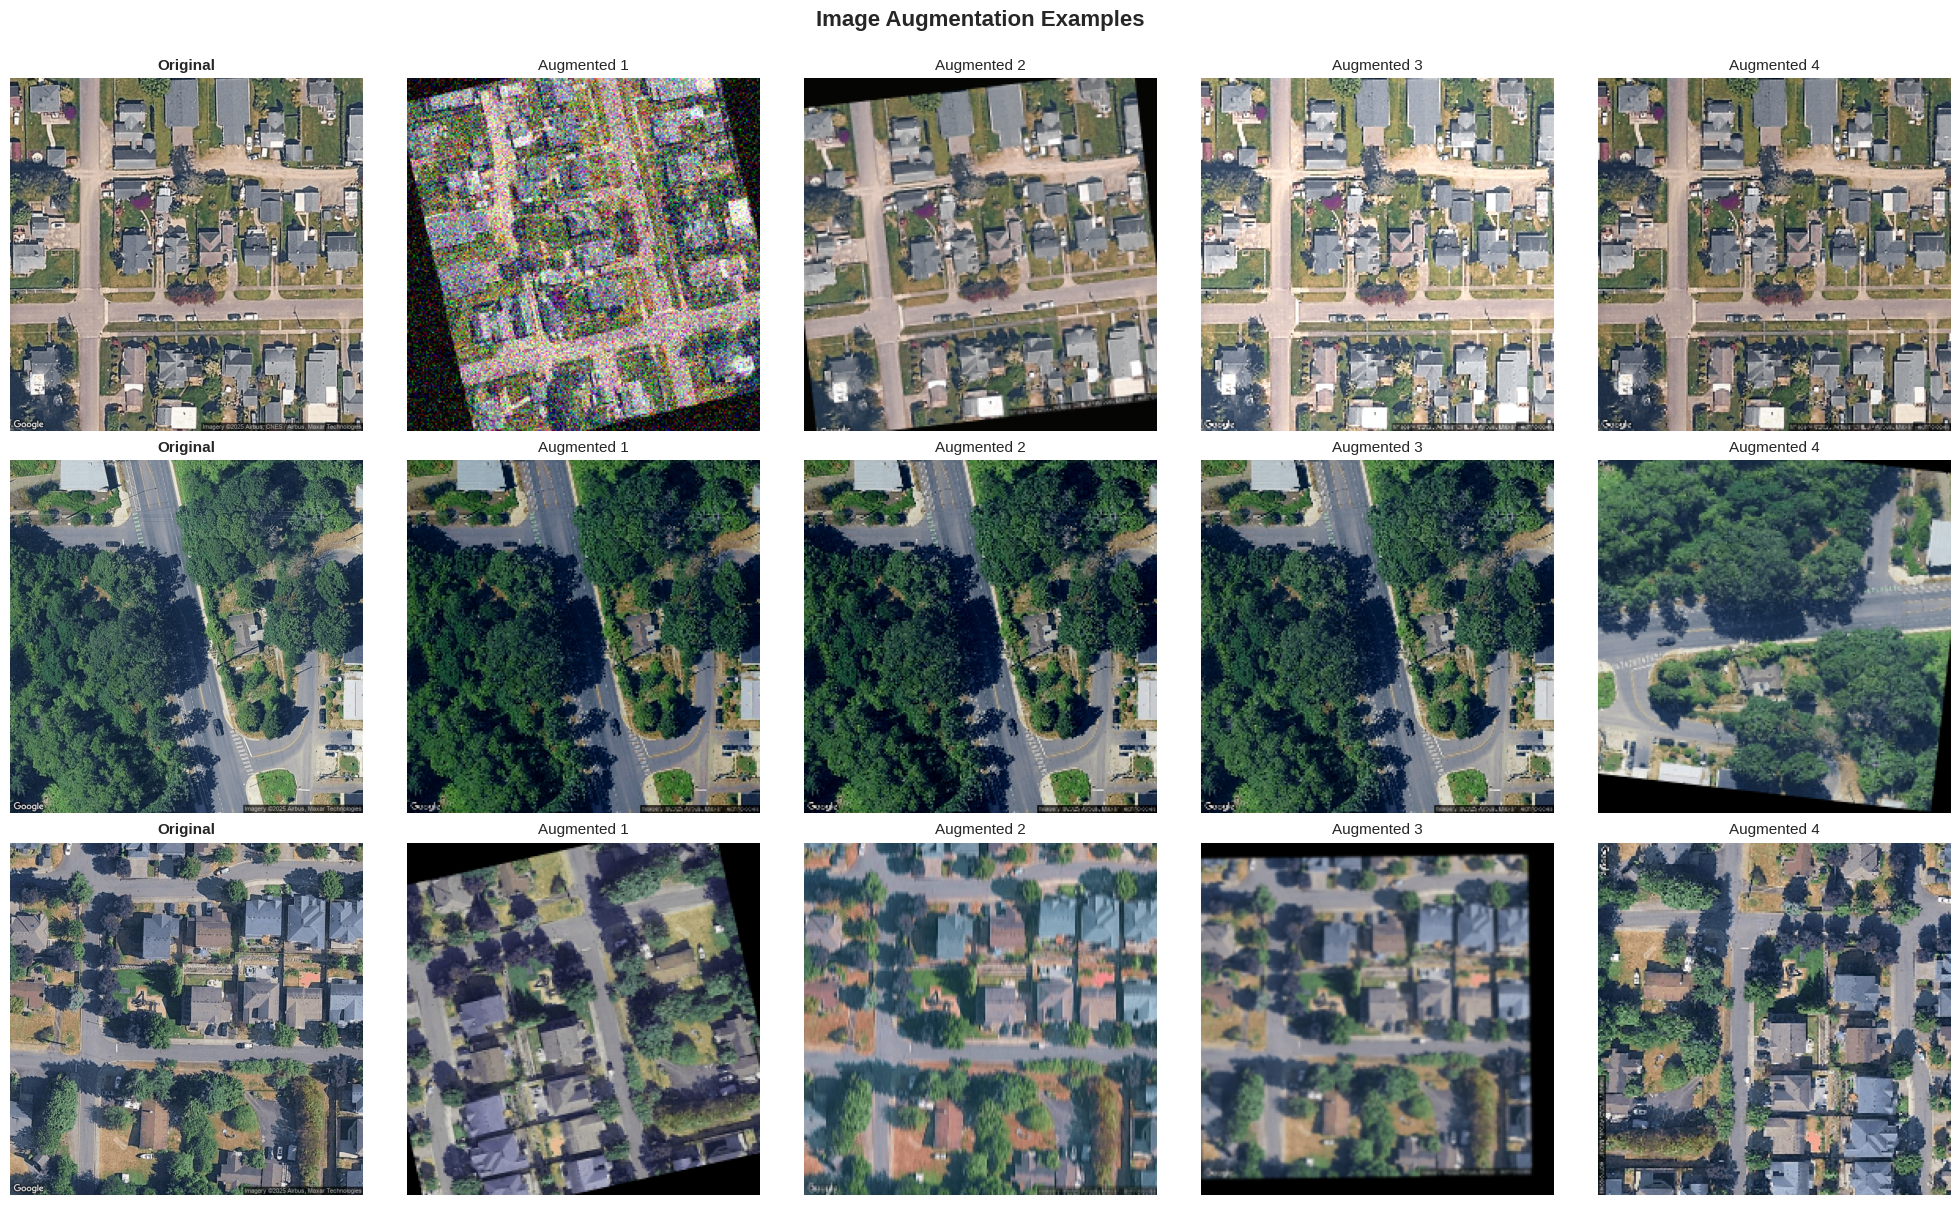

In [17]:
def visualize_augmentations(df, image_dir, image_col='image_name', n_examples=3):
    """
    Visualize original and augmented versions of images
    """
    train_transform = get_train_transforms()

    sample_df = df.sample(n_examples)

    fig, axes = plt.subplots(n_examples, 5, figsize=(20, 4*n_examples))

    for row_idx, (_, sample) in enumerate(sample_df.iterrows()):
        img_path = os.path.join(image_dir, sample[image_col])

        if not os.path.exists(img_path):
            continue

        # Load original
        original = cv2.imread(img_path)
        original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

        # Display original
        axes[row_idx, 0].imshow(original)
        axes[row_idx, 0].set_title('Original', fontsize=11, fontweight='bold')
        axes[row_idx, 0].axis('off')

        # Display 4 augmented versions
        for col_idx in range(1, 5):
            augmented = train_transform(image=original)['image']

            # Convert from tensor to numpy for display
            aug_img = augmented.permute(1, 2, 0).numpy()

            # Denormalize for display
            aug_img = aug_img * np.array(IMAGE_STD) + np.array(IMAGE_MEAN)
            aug_img = np.clip(aug_img, 0, 1)

            axes[row_idx, col_idx].imshow(aug_img)
            axes[row_idx, col_idx].set_title(f'Augmented {col_idx}', fontsize=11)
            axes[row_idx, col_idx].axis('off')

    plt.suptitle('Image Augmentation Examples', fontsize=16, fontweight='bold', y=1.0)
    plt.tight_layout()
    plt.show()

# Visualize
print("\n🎨 Visualizing augmentation pipeline...")
visualize_augmentations(train_df, TRAIN_IMAGE_DIR, 'image_name', n_examples=3)

---
## 4. FEATURE SELECTION

Select the most important features for modeling.

### 4.1 Prepare Features for Selection

In [18]:
# Identify feature columns (exclude ID, target, categorical text columns, etc.)
exclude_cols = ['id', 'date', 'price', 'image_name', 'price_category',
                'season', 'age_category', 'grade_category', 'vegetation_category',
                'urbanization_level', 'brightness_category', 'quadrant', 'geo_grid']

# Get numerical features
numerical_features = [col for col in train_df.columns
                     if col not in exclude_cols
                     and train_df[col].dtype in ['int64', 'float64', 'int32', 'float32']]

print(f"Total numerical features: {len(numerical_features)}")
print(f"\nNumerical features:")
for i, col in enumerate(numerical_features, 1):
    print(f"  {i}. {col}")

Total numerical features: 69

Numerical features:
  1. bedrooms
  2. bathrooms
  3. sqft_living
  4. sqft_lot
  5. floors
  6. waterfront
  7. view
  8. condition
  9. grade
  10. sqft_above
  11. sqft_basement
  12. yr_built
  13. yr_renovated
  14. zipcode
  15. lat
  16. long
  17. sqft_living15
  18. sqft_lot15
  19. greenness
  20. blueness
  21. brightness
  22. edge_density
  23. year_sold
  24. month_sold
  25. quarter_sold
  26. day_of_week
  27. is_weekend
  28. property_age
  29. is_renovated
  30. years_since_renovation
  31. living_to_lot_ratio
  32. lot_coverage
  33. above_ground_ratio
  34. has_basement
  35. basement_ratio
  36. sqft_per_bedroom
  37. sqft_per_bathroom
  38. bathroom_to_bedroom_ratio
  39. total_rooms
  40. sqft_per_floor
  41. living_vs_neighbors
  42. living_premium
  43. lot_vs_neighbors
  44. lot_premium
  45. quality_score
  46. quality_weighted_size
  47. has_view
  48. excellent_view
  49. premium_features_count
  50. dist_from_center
  51. nort

### 4.2 Handle Missing Values and Outliers

In [19]:
# Check for missing values
missing_in_features = train_df[numerical_features].isnull().sum()
print("Missing values in features:")
print(missing_in_features[missing_in_features > 0])

# Fill missing values
if missing_in_features.sum() > 0:
    print("\nFilling missing values with median...")
    for col in numerical_features:
        if train_df[col].isnull().sum() > 0:
            median_val = train_df[col].median()
            train_df[col].fillna(median_val, inplace=True)
            test_df[col].fillna(median_val, inplace=True)
    print("✅ Missing values filled")

# Check for infinite values
inf_count = np.isinf(train_df[numerical_features]).sum().sum()
if inf_count > 0:
    print(f"\n⚠️ Found {inf_count} infinite values. Replacing with large values...")
    train_df[numerical_features] = train_df[numerical_features].replace([np.inf, -np.inf], np.nan)
    test_df[numerical_features] = test_df[numerical_features].replace([np.inf, -np.inf], np.nan)

    for col in numerical_features:
        if train_df[col].isnull().sum() > 0:
            median_val = train_df[col].median()
            train_df[col].fillna(median_val, inplace=True)
            test_df[col].fillna(median_val, inplace=True)
    print("✅ Infinite values handled")

Missing values in features:
Series([], dtype: int64)


### 4.3 Feature Importance Analysis


📊 Correlation-based Feature Importance...

Top 20 features by correlation with price:
quality_weighted_size         0.758346
size_quality_interaction      0.755327
sqft_living                   0.700933
urban_size_interaction        0.692586
size_condition_interaction    0.671352
grade                         0.664266
zipcode_mean_price            0.643278
sqft_per_bedroom              0.631078
sqft_above                    0.602648
quality_score                 0.601874
sqft_living15                 0.581781
bathrooms                     0.525487
sqft_per_bathroom             0.519495
total_rooms                   0.463855
sqft_per_floor                0.433404
living_vs_neighbors           0.401853
view                          0.390534
premium_features_count        0.377381
bathroom_to_bedroom_ratio     0.367082
has_view                      0.355841
Name: price, dtype: float64


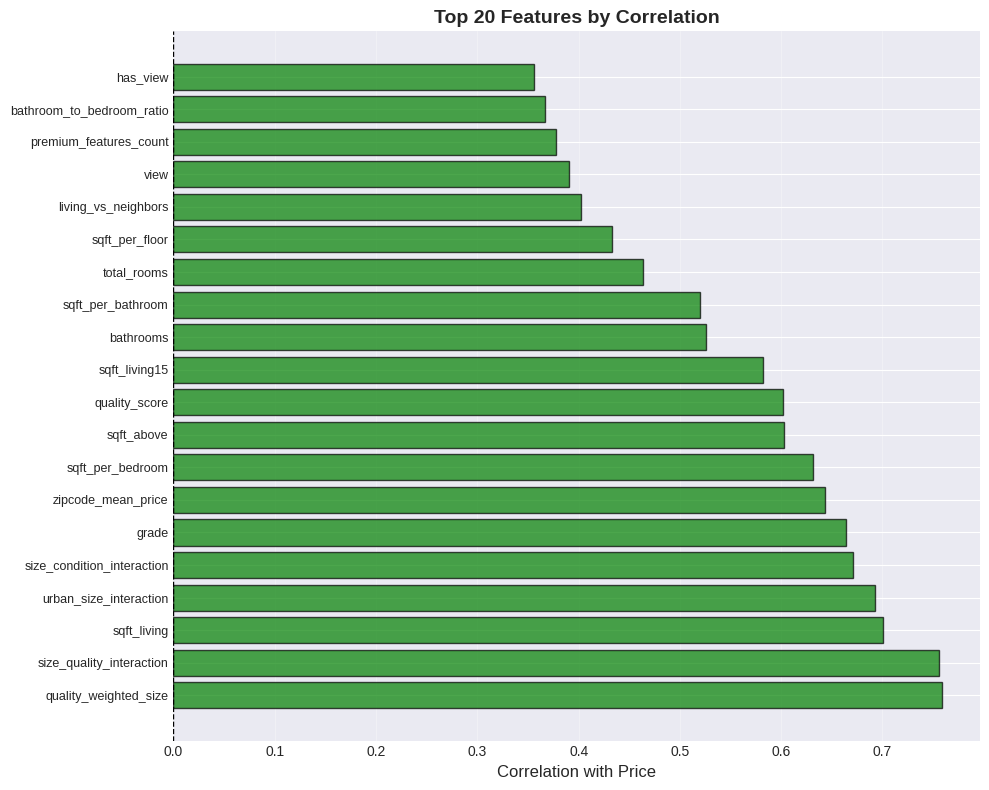

In [20]:
# Correlation-based feature importance
print("\n📊 Correlation-based Feature Importance...")
correlations = train_df[numerical_features + ['price']].corr()['price'].drop('price')
correlations_abs = correlations.abs().sort_values(ascending=False)

print("\nTop 20 features by correlation with price:")
print(correlations_abs.head(20))

# Visualize
plt.figure(figsize=(10, 8))
top_20_corr = correlations.reindex(correlations_abs.head(20).index)
colors = ['green' if x > 0 else 'red' for x in top_20_corr.values]
plt.barh(range(len(top_20_corr)), top_20_corr.values, color=colors, alpha=0.7, edgecolor='black')
plt.yticks(range(len(top_20_corr)), top_20_corr.index, fontsize=9)
plt.xlabel('Correlation with Price', fontsize=12)
plt.title('Top 20 Features by Correlation', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


🌲 Random Forest Feature Importance...
Training Random Forest (this may take a minute)...

Top 20 features by Random Forest importance:
quality_weighted_size          0.478527
zipcode_mean_price             0.139466
size_quality_interaction       0.092447
dist_from_center               0.082022
lat                            0.017950
sqft_living                    0.016992
waterfront                     0.013091
view_waterfront_interaction    0.010078
sqft_living15                  0.008309
sqft_above                     0.007906
premium_features_count         0.007814
sqft_lot15                     0.007320
edge_density                   0.006858
size_condition_interaction     0.006023
sqft_lot                       0.005030
living_vs_neighbors            0.004951
brightness                     0.004607
sqft_per_bedroom               0.004318
view                           0.004155
bathrooms                      0.004126
dtype: float64


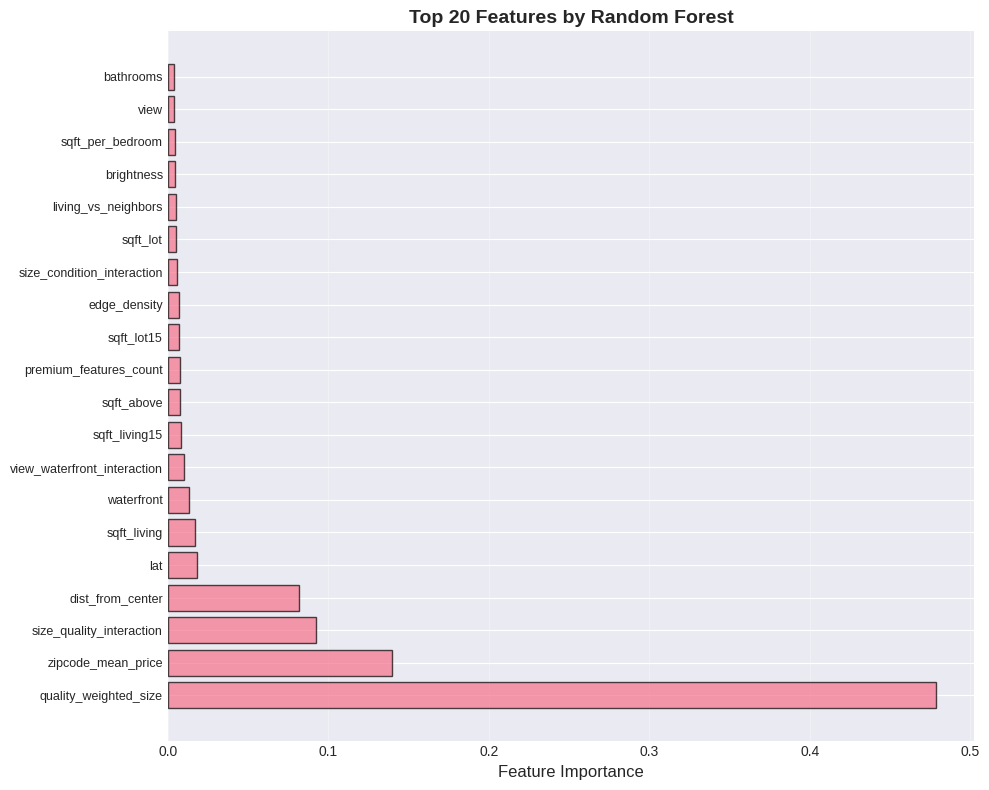

In [21]:
# Random Forest feature importance
print("\n🌲 Random Forest Feature Importance...")
print("Training Random Forest (this may take a minute)...")

# Sample for faster computation
sample_size = min(5000, len(train_df))
sample_df = train_df.sample(sample_size, random_state=42)

X_sample = sample_df[numerical_features]
y_sample = sample_df['price']

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_sample, y_sample)

# Get feature importances
feature_importance = pd.Series(rf.feature_importances_, index=numerical_features)
feature_importance = feature_importance.sort_values(ascending=False)

print("\nTop 20 features by Random Forest importance:")
print(feature_importance.head(20))

# Visualize
plt.figure(figsize=(10, 8))
top_20_rf = feature_importance.head(20)
plt.barh(range(len(top_20_rf)), top_20_rf.values, alpha=0.7, edgecolor='black')
plt.yticks(range(len(top_20_rf)), top_20_rf.index, fontsize=9)
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Top 20 Features by Random Forest', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 4.4 Select Final Features

In [25]:
# Combine both methods
top_corr_features = set(correlations_abs.head(20).index)
top_rf_features = set(feature_importance.head(20).index)

# Union of both
selected_features = list(top_corr_features | top_rf_features)

# Always include key features
must_have_features = ['sqft_living', 'grade', 'lat', 'long', 'property_age',
                      'greenness', 'blueness', 'edge_density', 'waterfront']
must_have_features = [f for f in must_have_features if f in numerical_features]

selected_features = list(set(selected_features) | set(must_have_features))
selected_features.sort()

print("="*80)
print("FINAL FEATURE SELECTION")
print("="*80)
print(f"Total features available: {len(numerical_features)}")
print(f"Selected features: {len(selected_features)}")
print(f"\nSelected feature list:")
for i, feat in enumerate(selected_features, 1):
    print(f"  {i}. {feat}")

# Save selected features list
SELECTED_FEATURES = selected_features

FINAL FEATURE SELECTION
Total features available: 69
Selected features: 32

Selected feature list:
  1. bathroom_to_bedroom_ratio
  2. bathrooms
  3. blueness
  4. brightness
  5. dist_from_center
  6. edge_density
  7. grade
  8. greenness
  9. has_view
  10. lat
  11. living_vs_neighbors
  12. long
  13. premium_features_count
  14. property_age
  15. quality_score
  16. quality_weighted_size
  17. size_condition_interaction
  18. size_quality_interaction
  19. sqft_above
  20. sqft_living
  21. sqft_living15
  22. sqft_lot
  23. sqft_lot15
  24. sqft_per_bathroom
  25. sqft_per_bedroom
  26. sqft_per_floor
  27. total_rooms
  28. urban_size_interaction
  29. view
  30. view_waterfront_interaction
  31. waterfront
  32. zipcode_mean_price


---
## 5. DATA PREPARATION FOR MODELING

### 5.1 Scale Features

In [27]:
# Initialize scaler (RobustScaler handles outliers better)
scaler = RobustScaler()

# Fit on training data
X_train_scaled = scaler.fit_transform(train_df[SELECTED_FEATURES])
# X_test_scaled = scaler.transform(test_df[SELECTED_FEATURES])

# Create scaled dataframes
train_df_scaled = train_df.copy()
# test_df_scaled = test_df.copy()

train_df_scaled[SELECTED_FEATURES] = X_train_scaled
# test_df_scaled[SELECTED_FEATURES] = X_test_scaled

print("✅ Features scaled using RobustScaler")
print(f"\nScaled feature statistics:")
print(train_df_scaled[SELECTED_FEATURES].describe())

✅ Features scaled using RobustScaler

Scaled feature statistics:
       bathroom_to_bedroom_ratio     bathrooms      blueness    brightness  \
count               16209.000000  16209.000000  16209.000000  16209.000000   
mean                   -0.072492     -0.136946      0.008214     -0.050307   
std                     0.735687      0.765242      0.764707      0.669782   
min                    -2.400000     -2.250000     -4.225376     -2.912353   
25%                    -0.600000     -0.750000     -0.490304     -0.520557   
50%                     0.000000      0.000000      0.000000      0.000000   
75%                     0.400000      0.250000      0.509696      0.479443   
max                     9.600000      5.750000      3.991873      2.439598   

       dist_from_center  edge_density         grade     greenness  \
count      16209.000000  16209.000000  16209.000000  16209.000000   
mean           0.115396     -0.039017      0.652971     -0.080559   
std            0.642109  

### 5.2 Train-Validation Split

DATA SPLIT
Training set: 12967 samples (80.0%)
Validation set: 3242 samples (20.0%)


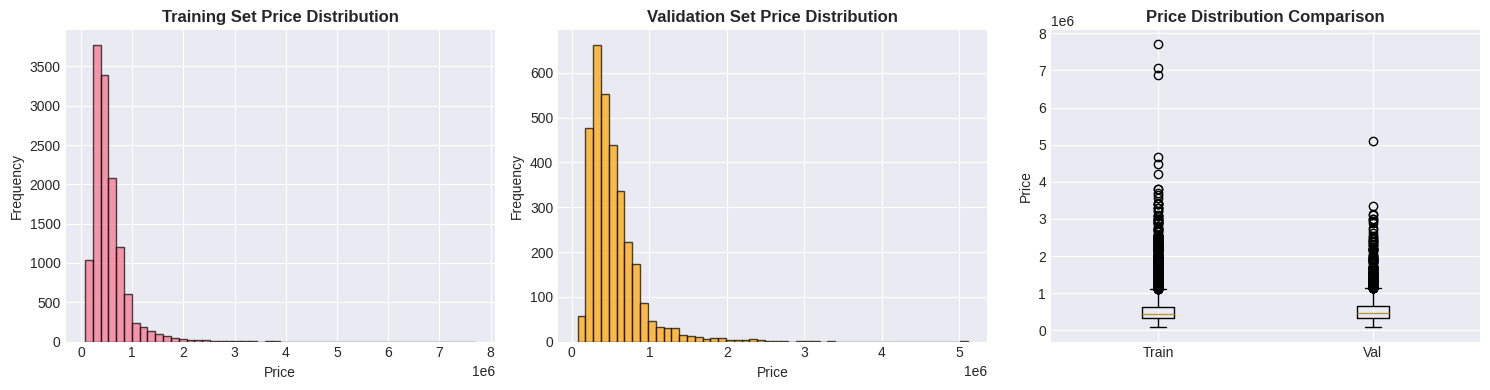

In [28]:
# Create train-validation split
train_data, val_data = train_test_split(train_df_scaled, test_size=0.2, random_state=42)

print("="*80)
print("DATA SPLIT")
print("="*80)
print(f"Training set: {len(train_data)} samples ({100*len(train_data)/len(train_df_scaled):.1f}%)")
print(f"Validation set: {len(val_data)} samples ({100*len(val_data)/len(train_df_scaled):.1f}%)")
# print(f"Test set: {len(test_df_scaled)} samples")

# Check price distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(train_data['price'], bins=50, alpha=0.7, edgecolor='black')
axes[0].set_title('Training Set Price Distribution', fontweight='bold')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')

axes[1].hist(val_data['price'], bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[1].set_title('Validation Set Price Distribution', fontweight='bold')
axes[1].set_xlabel('Price')
axes[1].set_ylabel('Frequency')

axes[2].boxplot([train_data['price'], val_data['price']], labels=['Train', 'Val'])
axes[2].set_title('Price Distribution Comparison', fontweight='bold')
axes[2].set_ylabel('Price')

plt.tight_layout()
plt.show()

### 5.3 Save Processed Data

In [29]:
# Create output directory
os.makedirs('./processed_data', exist_ok=True)

# Save processed datasets
train_data.to_csv('./processed_data/train_processed.csv', index=False)
val_data.to_csv('./processed_data/val_processed.csv', index=False)
# test_df_scaled.to_csv('./processed_data/test_processed.csv', index=False)

# Save feature list
with open('./processed_data/selected_features.txt', 'w') as f:
    for feat in SELECTED_FEATURES:
        f.write(f"{feat}\n")

# Save scaler
import joblib
joblib.dump(scaler, './processed_data/feature_scaler.pkl')

# Save image normalization parameters
np.save('./processed_data/image_mean.npy', IMAGE_MEAN)
np.save('./processed_data/image_std.npy', IMAGE_STD)

print("✅ All processed data saved!")
print("\nSaved files:")
print("  - train_processed.csv")
print("  - val_processed.csv")
print("  - test_processed.csv")
print("  - selected_features.txt")
print("  - feature_scaler.pkl")
print("  - image_mean.npy")
print("  - image_std.npy")

✅ All processed data saved!

Saved files:
  - train_processed.csv
  - val_processed.csv
  - test_processed.csv
  - selected_features.txt
  - feature_scaler.pkl
  - image_mean.npy
  - image_std.npy


### 5.4 Create DataLoaders

In [31]:
# Create datasets
train_dataset = PropertyImageDataset(
    df=train_data,
    image_dir=TRAIN_IMAGE_DIR,
    image_col='image_name',
    transform=get_train_transforms(),
    include_features=True,
    feature_cols=SELECTED_FEATURES
)

val_dataset = PropertyImageDataset(
    df=val_data,
    image_dir=TRAIN_IMAGE_DIR,
    image_col='image_name',
    transform=get_val_transforms(),
    include_features=True,
    feature_cols=SELECTED_FEATURES
)

# test_dataset = PropertyImageDataset(
#     df=test_df_scaled,
#     image_dir=TEST_IMAGE_DIR,
#     image_col='image_name',
#     transform=get_val_transforms(),
#     include_features=True,
#     feature_cols=SELECTED_FEATURES
# )

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# test_loader = DataLoader(
#     test_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     num_workers=2,
#     pin_memory=True
# )

print("✅ DataLoaders created!")
print(f"\nBatches per epoch:")
print(f"  Training: {len(train_loader)} batches")
print(f"  Validation: {len(val_loader)} batches")
# print(f"  Test: {len(test_loader)} batches")

Valid images: 12967/12967
Valid images: 3242/3242
✅ DataLoaders created!

Batches per epoch:
  Training: 406 batches
  Validation: 102 batches


### 5.5 Test DataLoader


🧪 Testing DataLoader...

Batch structure:
  Images shape: torch.Size([32, 3, 224, 224])
  Features shape: torch.Size([32, 32])
  Targets shape: torch.Size([32])
  IDs: [252000400, 3541600210, 7135300026, 2436700625, 1522059120]...


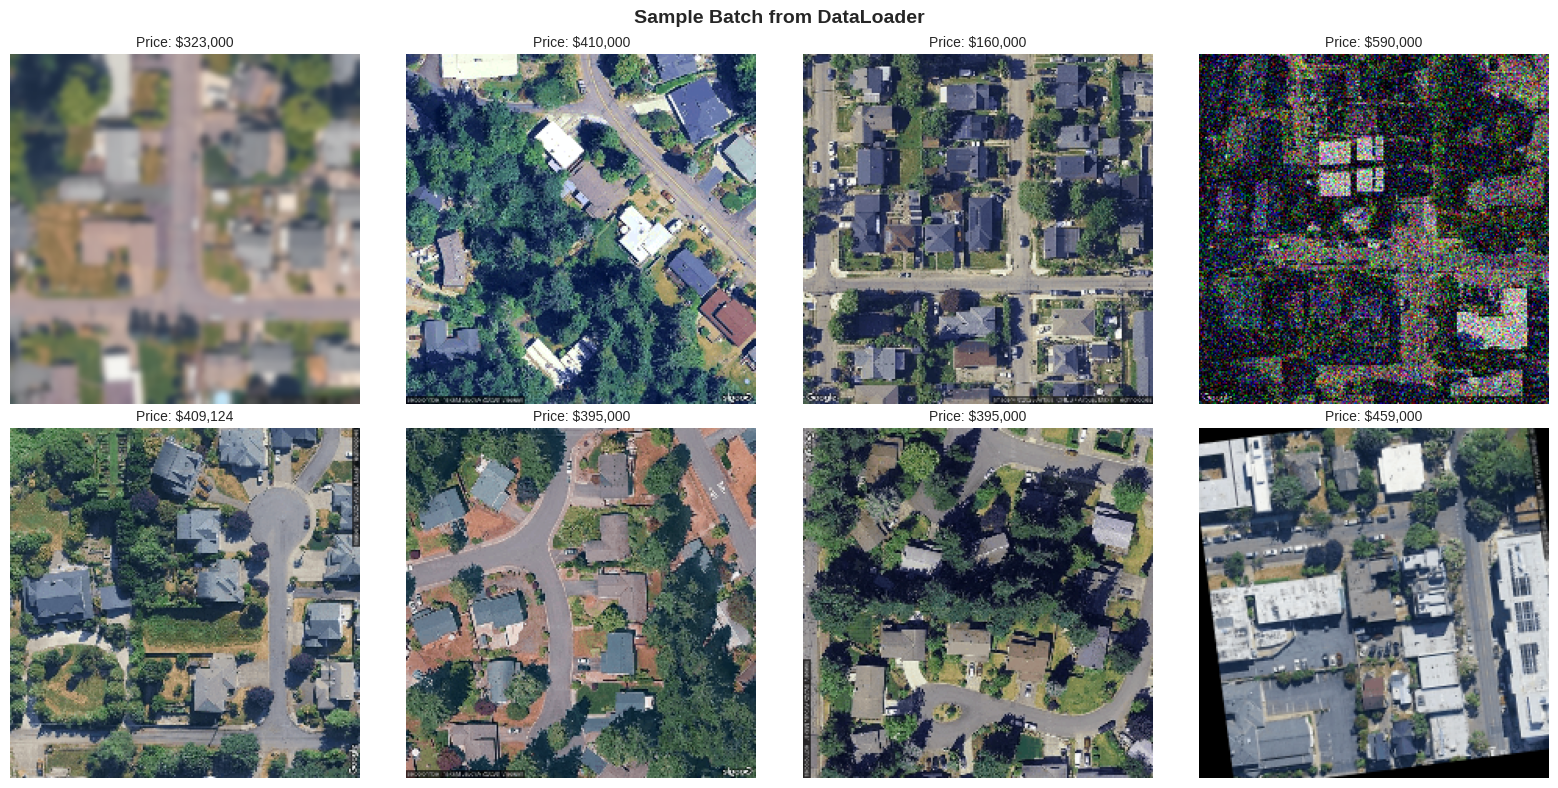


✅ DataLoader test successful!


In [32]:
# Test loading a batch
print("\n🧪 Testing DataLoader...")
batch = next(iter(train_loader))

print(f"\nBatch structure:")
print(f"  Images shape: {batch['image'].shape}")
print(f"  Features shape: {batch['features'].shape}")
print(f"  Targets shape: {batch['target'].shape}")
print(f"  IDs: {batch['id'][:5].tolist()}...")

# Visualize a batch
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(8):
    img = batch['image'][i].permute(1, 2, 0).numpy()
    # Denormalize
    img = img * np.array(IMAGE_STD) + np.array(IMAGE_MEAN)
    img = np.clip(img, 0, 1)

    axes[i].imshow(img)
    axes[i].set_title(f"Price: ${batch['target'][i].item():,.0f}", fontsize=10)
    axes[i].axis('off')

plt.suptitle('Sample Batch from DataLoader', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ DataLoader test successful!")

---
## 6. SUMMARY & NEXT STEPS

In [33]:
print("="*80)
print("FEATURE ENGINEERING & IMAGE PROCESSING SUMMARY")
print("="*80)

print("\n✅ COMPLETED TASKS:")
print("\n1. FEATURE ENGINEERING")
print(f"   • Created {len(train_df.columns) - 27} new features")
print("   • Temporal features: age, renovation, seasonality")
print("   • Size ratios: living/lot, per bedroom, per bathroom")
print("   • Quality scores: composite quality, premium count")
print("   • Location features: distance from center, geo-grids")
print("   • Visual features: vegetation, water, urbanization indices")
print("   • Interaction features: size×quality, location×quality, etc.")

print("\n2. FEATURE SELECTION")
print(f"   • Analyzed {len(numerical_features)} numerical features")
print(f"   • Selected {len(SELECTED_FEATURES)} most important features")
print("   • Used correlation analysis + Random Forest importance")

print("\n3. IMAGE PROCESSING PIPELINE")
print(f"   • Verified {len(train_df)} training images")
print(f"   • Standardized to {IMG_SIZE}×{IMG_SIZE} pixels")
print("   • Created augmentation pipeline (flips, rotations, color)")
print("   • Computed normalization parameters")
print("   • Built custom PyTorch dataset and dataloaders")

print("\n4. DATA PREPARATION")
print(f"   • Scaled features using RobustScaler")
print(f"   • Created train-validation split ({len(train_data)}/{len(val_data)} samples)")
# print(f"   • Prepared test set ({len(test_df_scaled)} samples)")
print("   • Saved all processed data and artifacts")

print("\n" + "="*80)
print("READY FOR MODEL TRAINING!")
print("="*80)

print("\n📁 OUTPUT FILES:")
print("   ./processed_data/")
print("   ├── train_processed.csv         (Training data with all features)")
print("   ├── val_processed.csv           (Validation data)")
print("   ├── test_processed.csv          (Test data)")
print("   ├── selected_features.txt       (List of selected features)")
print("   ├── feature_scaler.pkl          (Fitted scaler object)")
print("   ├── image_mean.npy              (Image normalization mean)")
print("   └── image_std.npy               (Image normalization std)")

print("\n🚀 NEXT STEPS:")
print("   1. Build baseline models (tabular-only, image-only)")
print("   2. Develop multimodal fusion architecture")
print("   3. Train with cross-validation")
print("   4. Implement Grad-CAM for explainability")
print("   5. Generate predictions on test set")
print("   6. Create project report with visualizations")

FEATURE ENGINEERING & IMAGE PROCESSING SUMMARY

✅ COMPLETED TASKS:

1. FEATURE ENGINEERING
   • Created 55 new features
   • Temporal features: age, renovation, seasonality
   • Size ratios: living/lot, per bedroom, per bathroom
   • Quality scores: composite quality, premium count
   • Location features: distance from center, geo-grids
   • Visual features: vegetation, water, urbanization indices
   • Interaction features: size×quality, location×quality, etc.

2. FEATURE SELECTION
   • Analyzed 69 numerical features
   • Selected 32 most important features
   • Used correlation analysis + Random Forest importance

3. IMAGE PROCESSING PIPELINE
   • Verified 16209 training images
   • Standardized to 224×224 pixels
   • Created augmentation pipeline (flips, rotations, color)
   • Computed normalization parameters
   • Built custom PyTorch dataset and dataloaders

4. DATA PREPARATION
   • Scaled features using RobustScaler
   • Created train-validation split (12967/3242 samples)
   • Sav